 **Create and Run a local RAG pipeline from scratch**

## 1. Document/text preprocessing and embedding creation

In [2]:
import os
import requests

# Get PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    # Enter the URL of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # THe Local filename to save the downloaded file
    filename = pdf_path

    # Send a GET request to the URL
    responce = requests.get(url)

    # Check if the request was successfull
    if responce.status_code == 200:
        # Open the file and save it
        with open(filename , 'wb') as file:
            file.write(responce.content)
        print(f"[INFO] The file has been download and saved as {filename}")
    else:
        print(f"[INFO] Falied to download the file . Status code {responce.status_code}")

else:
    print(f"File {pdf_path} exists.")


File human-nutrition-text.pdf exists.


In [3]:
import fitz
from tqdm import tqdm


def text_formaatter(text: str) -> str:
    """ Performs minor formatting on text """
    cleaned_text = text.replace("\n" , " ").strip()

    # Pottentially more text formating functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number , page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formaatter(text=text)
        pages_and_text.append({"page_number" : page_number - 41 , 
                               "page_char_count": len(text) , 
                               "page_word_count": len(text.split(" ")) , 
                               "page_sentence_count_raw": len(text.split(". ")) , 
                               "page_token_count": len(text) / 4  , # 1 token = 4 character.
                               "text": text})
    
    return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path=pdf_path)
pages_and_text[:2]


1208it [00:01, 862.34it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import random
random.sample(pages_and_text , k = 4)

[{'page_number': 761,
  'page_char_count': 1398,
  'page_word_count': 290,
  'page_sentence_count_raw': 13,
  'page_token_count': 349.5,
  'text': 'Table 12.6 The Different Categories from the Pacific  Energy  Nutrient-dense  foods  Protective Foods  Body-building  Foods  Types of  Foods  Foods that are  both high in  calories and high  in nutrients  Fruits and vegetables  Protein-rich  foods  Description  The  recommendation  is that these foods  should be  included in all  meals  contributing to  about half of the  food you  consume each  day.  The foods in this  group are high in  vitamins and minerals.  These foods are  recommended to be  \xa0included in all meals  and snacks  contributing about  one third of the food  consumed each day.  The foods in  this group are  high in  protein and is  recommended  to be eaten  twice a day in  small  amounts.  The recommendation is that these foods should be included in all  meals contributing to about half of the food you consume each day. 

In [5]:
import pandas as pd 

df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.004139,198.299669,9.972682,287.001035
std,348.86387,560.382275,95.759336,6.187226,140.095569
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.000000,134.000000,4.000000,190.500000
50%,562.50000,1231.500000,214.500000,10.000000,307.875000
75%,864.25000,1603.500000,271.000000,14.000000,400.875000
max,1166.00000,2308.000000,429.000000,32.000000,577.000000


**Further text processing (splitting pages into sentences)**

In [7]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This is another sentenece. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentence split
list(doc.sents)

[This is a sentence., This is another sentenece., I like elephants.]

In [8]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item["text"]).sents)

    # Make sure all sentences are string (the default type is a spacyy datatype)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the senteneces
    item["page_sentence_count_spacy"] = len(item["sentences"])


100%|██████████| 1208/1208 [00:01<00:00, 958.75it/s] 


In [9]:
random.sample(pages_and_text , k = 1)

[{'page_number': 809,
  'page_char_count': 1750,
  'page_word_count': 261,
  'page_sentence_count_raw': 12,
  'page_token_count': 437.5,
  'text': 'breastfeed. Once a new mother has left the hospital for home, she  needs access to a trained individual who can provide consistent  information. International Board Certified Lactation Consultants  (IBCLCs) are health-care professionals (often a registered nurse or  registered dietitian) certified in breastfeeding management that  work with new mothers to solve problems and educate families  about the benefits of this practice. Research shows that  breastfeeding rates are higher among women who had infants in  hospitals that make IBCLCs available to new mothers, rather than  those who gave birth in institutions without these professionals on  staff.3  Other important practices for maternity hospitals to support  breastfeeding are summarized in the Ten Steps to Successful  Breastfeeding, launched jointly by the WHO and UNICEF.4 These  recomm

In [10]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chucking our sentence together

In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split a list of texts recursively into chunk size

def split_list(input_list: list[str] , slice_size : int = num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i : i + slice_size] for i in range(0 , len(input_list) , slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_text):
    item["sentence_chunks"] = split_list(input_list=item["sentences"] , slice_size=num_sentence_chunk_size)

    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 232035.14it/s]


In [13]:
random.sample(pages_and_text , k = 1)

[{'page_number': 1093,
  'page_char_count': 1670,
  'page_word_count': 266,
  'page_sentence_count_raw': 17,
  'page_token_count': 417.5,
  'text': 'develop osteoporosis and sometimes it occurs very early in life.12  Women with anorexia nervosa are especially at risk because they  not only have inadequate nutrition and low body weight, but also  the illness is also associated with estrogen deficiency.  Smoking, Alcohol, and Caffeine  Smoking cigarettes has long been connected to a decrease in BMD  and an increased risk for osteoporosis and fractures. However,  because people who smoke are more likely to be physically inactive  and have poor diets, it is difficult to determine whether smoking  itself causes osteoporosis. What is more, smoking is linked to earlier  menopause and therefore the increased risk for developing  osteoporosis among female smokers may also be attributed, at least  in part, to having stopped estrogen production at an earlier age. A  review of several studies, pub

In [14]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

In [15]:
import re

# Split each chunk into own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  " , " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])' , r'. \1' , joined_sentence_chunk) # ".A" => ". A" (will work for any capital letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 17512.33it/s]


1843

In [16]:
random.sample(pages_and_chunks , k = 1)

[{'page_number': 1158,
  'sentence_chunk': 'Vitamins reused “Digestive system without labels” by Mariana Ruiz / Public Domain; “Simple columnar epithelial cells” by McortNGHH / CC BY 3.0 22. Figure 9.5 The Functions of Vitamin D reused “Female silhouette” by Pnx / Public Domain; “Liver” by Maritacovarrubias / Public Domain; “Kidney-reins” by Belcirelk / Public Domain; “Organs of the human body” by Mothsart / Public Domain; “A human humerus arm bone” by kephalian_cosmos/ Public Domain; “Sun” by Puren / Public Domain 23. Figure 9.10 The Role of Thiamin reused “Beta-D Glucopryranose” by Neurotiker / Public Domain 24. Figure 9.12 \xa0Conversion of Tryptophan to Niacin reused “Chicken with potatoes” by Machovka / Public Domain 25. Figure 9.17 Folate and the Formation of Macrocytic Anemia reused “Diagram showing the development of different blood cells from haematopoietic stem cells to mature cells” by Mikael Haggstrom / CC BY-SA 3.0; “Red blood cell” by Database Center for Life Science / CC

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filter chunks of text for short chunks

In [18]:
min_token_length = 30

In [19]:
# Filter our DataFrame for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient = "records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
random.sample(pages_and_chunks_over_min_token_len , k = 1)

[{'page_number': 240,
  'sentence_chunk': 'But mechanical breakdown is ongoing—the strong peristaltic contractions of the stomach mix the carbohydrates into the more uniform mixture of chyme. Figure 4.6 Salivary Glands in the Mouth 240 | Digestion and Absorption of Carbohydrates',
  'chunk_char_count': 236,
  'chunk_word_count': 35,
  'chunk_token_count': 59.0}]

## Embedding our text chunks

In [20]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2" , device = "mps")

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
"Sentences can be embedded one by one or in a list.",
"I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences , embeddings))

# See the embeddings
for sentence , embedding in embeddings_dict.items():
    print(f"Sentences: {sentences}")
    print(f"Embedding: {embedding}")
    print("")

/Users/pandhari/Desktop/NLP/NLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentences: ['The Sentence Transformer library provides an easy way to create embeddings.', 'Sentences can be embedded one by one or in a list.', 'I like horses!']
Embedding: [-3.44285034e-02  2.95328740e-02 -2.33643129e-02  5.57257049e-02
 -2.19098348e-02 -6.47064066e-03  1.02849510e-02 -6.57804459e-02
  2.29718108e-02 -2.61120982e-02  3.80421579e-02  5.61402477e-02
 -3.68746743e-02  1.52788563e-02  4.37020771e-02 -5.19723520e-02
  4.89479378e-02  3.58104357e-03 -1.29750213e-02  3.54386633e-03
  4.23262045e-02  3.52606587e-02  2.49401722e-02  2.99177412e-02
 -1.99381504e-02 -2.39753220e-02 -3.33373318e-03 -4.30450179e-02
  5.72013743e-02 -1.32517647e-02 -3.54478061e-02 -1.13935862e-02
  5.55561855e-02  3.61094647e-03  8.88527211e-07  1.14027150e-02
 -3.82229984e-02 -2.43550329e-03  1.51313534e-02 -1.32587040e-04
  5.00659235e-02 -5.50876968e-02  1.73444599e-02  5.00958897e-02
 -3.75959873e-02 -1.04462970e-02  5.08322604e-02  1.24860760e-02
  8.67376551e-02  4.64143828e-02 -2.10689977e-

In [44]:
embeddings[0].shape

(768,)

In [46]:
%%time

embedding_model.to("mps")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 1680/1680 [02:57<00:00,  9.48it/s]

CPU times: user 6min 24s, sys: 1min 11s, total: 7min 36s
Wall time: 2min 57s


In [47]:
%%time

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[523]

CPU times: user 258 μs, sys: 2.75 ms, total: 3.01 ms
Wall time: 3.69 ms


'through food. Genetic factors may also influence the way a person’s body modifies cholesterol. The 2015-2020 US Dietary Guidelines suggest limiting saturated fats, thereby indirectly limiting dietary cholesterol since foods that are high in cholesterol tend to be high in saturated fats also. A Prelude to Disease If left unchecked, improper dietary fat consumption can lead down a path to severe health problems. An increased level of lipids, triglycerides, and cholesterol in the blood is called hyperlipidemia. Hyperlipidemia is inclusive of several conditions but more commonly refers to high cholesterol and triglyceride levels. When blood lipid levels are high, any number of adverse health problems may ensue. Consider the following: • Cardiovascular disease. According to the AHA, cardiovascular disease encompasses a variety of problems, many of which are related to the process of atherosclerosis. Over time the arteries thicken and harden with plaque buildup, causing restricted or at tim

In [48]:
len(text_chunks)

1680

In [50]:
%%time

# Embed all texts in batches
text_chunks_embeddings = embedding_model.encode(text_chunks , batch_size=32 ,convert_to_tensor=True)

text_chunks_embeddings


CPU times: user 30.3 s, sys: 16.6 s, total: 46.9 s
Wall time: 2min 36s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='mps:0')

# Save embeddings to file


In [51]:
pages_and_chunks_over_min_token_len[412]

{'page_number': 273,
 'sentence_chunk': 'Foods Total Carbohydrates Sugars Fiber Added Sugars Banana 27 (1 medium) 14.40 3.1 0 Lentils 40 (1 c.) 3.50 16.0 0 Snap beans 8.7 (1 c.) 1.60 4.0 0 Green pepper 5.5 (1 medium) 2.90 2.0 0 Corn tortilla 10.7 (1) 0.20 1.5 0 Bread, wheat bran 17.2 (1 slice) 3.50 1.4 3.4 Bread, rye 15.5 (1 slice) 1.20 1.9 1.0 Bagel (plain) 53 (1 medium) 5.30 2.3 4.8 Brownie 36 (1 square) 20.50 1.2 20.0 Oatmeal cookie 22.3 (1 oz.) 12.00 2.0 7.7 Cornflakes 23 (1 c.) 1.50 0.3 1.5 Pretzels 47 (10 twists) 1.30 1.7 0 Popcorn (homemade) 58 (100 g) 0.50 10.0 0 Skim milk 12 (1 c.) 12.00 0 0 Cream (half and half) 0.65 (1 Tbs.) 0.02 0 0 Cream substitute 1.0 (1 tsp.) 1.00 0 1.0 Cheddar cheese 1.3 (1 slice) 0.50 0 0 Yogurt (with fruit) 32.3 (6 oz.) 32.30 0 19.4 Caesar dressing 2.8 (1 Tbs.) 2.80 0 2.4 Sources: • National Nutrient Database for Standard Reference. US Department of Agriculture.http://www.nal.usda.gov/fnic/ foodcomp/search/. Updated December 7, 2011. Accessed Septembe

In [52]:
# Save embeddings to file 
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path , index=False)

In [21]:
# Import saved file and view
embeddings_df_save_path = "/Users/pandhari/Desktop/NLP/RAG/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242824e-02 9.02282149e-02 -5.09550050e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156195e-02 5.92139065e-02 -1.66167226e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801600e-02 3.39814052e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566985e-02 3.81274670e-02 -8.46854784e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264606e-02 -8.49768240e-03 9.57159232e-...


# RAG - Search and Answer

### Similarity search

In [22]:
import random
import torch
import numpy as np
import pandas as pd

device = "mps"

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("/Users/pandhari/Desktop/NLP/RAG/text_chunks_and_embeddings_df.csv")

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient= "records")

# Convert emedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]") , sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: Numpy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df["embedding"].tolist()) , dtype=torch.float32).to(device=device)
embeddings.shape


torch.Size([1680, 768])

In [23]:
# Create model
from sentence_transformers import util , SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2" , device=device)

/Users/pandhari/Desktop/NLP/NLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# 1. Define the query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed you query with the same model you embedding your passages
query_embedding = embedding_model.encode(query , convert_to_tensor=True)
query_embedding = query_embedding.to(device=device)

# 3. Get Similaity socre with the dot product (use cosine similarity if outputs of model aren't normalize)
from time import perf_counter as timer

start_time = timer()
dot_score = util.dot_score(a = query_embedding , b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

# 4. Get the top-k results (we'll keep top 5)
top_results = torch.topk(dot_score , k = 5)
top_results

Query: good foods for protein
[INFO] Time taken to get scores on 1680 embeddings: 0.00017 seconds


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634], device='mps:0'),
indices=tensor([611, 616, 615, 620, 617], device='mps:0'))

In [26]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [27]:
import textwrap

def print_wrapped(text , wrap_length = 80):
    wrapped_text = textwrap.fill(text , wrap_length)
    print(wrapped_text)


In [28]:
query = "good food for protein"
print(f"Query: {query}\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score , idx in zip(top_results[0] , top_results[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: good food for protein

Results:
Score: 0.7729
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page Number: 411


Score: 0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of
ways

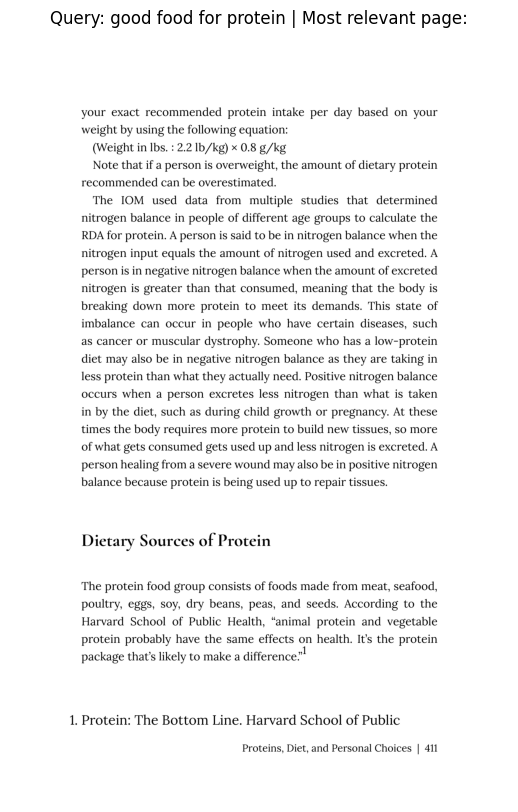

In [29]:
import fitz # pymupdf Library

# open PDF and Load target
pdf_path = pdf_path
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41) # note: page numbers of our PDF start 41+

# Get the image of the page
img = page.get_pixmap(dpi = 300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv , dtype=np.uint8).reshape(img.h , img.w , img.n)


# Display the image using MatPlotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13 , 10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: Dot Product and Cosine similarity

In [30]:
import torch

def dot_products(vector1 , vector2):
    return torch.dot(vector1 , vector2)

def cosine_similarity(vector1 , vector2):
    dot_product = torch.dot(vector1 , vector2)

    # Get Eucludian/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))


    return dot_product / (norm_vector1 * norm_vector2)

# Examples vectors/tensors
vector1 = torch.tensor([1 , 2 , 3] , dtype=torch.float32)
vector2 = torch.tensor([1 , 2 , 3] , dtype=torch.float32)
vector3 = torch.tensor([4 ,5 , 6] , dtype=torch.float32)
vector4 = torch.tensor([-1 , -2 , -3] , dtype=torch.float32)

# Calculate dot product
print("Dot Product between vector1 and vector2 " , dot_products(vector1 , vector2))
print("Dot Product between vector1 and vector3 " , dot_products(vector1 , vector3))
print("Dot Product between vector1 and vector4 " , dot_products(vector1 , vector4))

# Calculate cosine similarity
print("Cosine Similarity between vector1 and vector2 " , cosine_similarity(vector1 , vector2))
print("Cosine Similarity  between vector1 and vector3 " , cosine_similarity(vector1 , vector3))
print("Cosine Similarity  between vector1 and vector4 " , cosine_similarity(vector1 , vector4))

Dot Product between vector1 and vector2  tensor(14.)
Dot Product between vector1 and vector3  tensor(32.)
Dot Product between vector1 and vector4  tensor(-14.)
Cosine Similarity between vector1 and vector2  tensor(1.0000)
Cosine Similarity  between vector1 and vector3  tensor(0.9746)
Cosine Similarity  between vector1 and vector4  tensor(-1.0000)


### Functionizing our semantic search pipeline

In [31]:
def retrieve_relevant_resources(query: str , embeddings: torch.tensor , model: SentenceTransformer = embedding_model , n_resources_to_return : int = 5 , print_time: bool = True):
    """Embeds a query with model and returns top k scores and indices from embeddings. """

    # Embed the query
    query_embedding = model.encode(query , convert_to_tensor=True)
    query_embedding = query_embedding.to("mps")

    embeddings = embeddings.to("mps")

    # Get dot products scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding , embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time - start_time:.5f} seconds.")
    
    scores , indices = torch.topk(input=dot_scores , k = n_resources_to_return)

    return scores , indices

def print_top_results_and_scores(query: str , embeddings: torch.tensor , pages_and_chunks: list[dict] = pages_and_chunks , n_resources_to_return: int = 5):
    """
    Finds relevant passages given a query and prints them out along with their scores. 
    """
    scores , indices = retrieve_relevant_resources(query=query , embeddings=embeddings , n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score , idx in zip(scores ,indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")


In [32]:
print_top_results_and_scores(query="foods high in fiber" , embeddings=embeddings)

[INFO] Time taken to get scores on (1680) embeddings: 0.00006 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page Number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent th

### Getting an LLM for Local generations

In [33]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb}GB")

In [34]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")


### Loading an LLM locally

In [37]:
import torch
from transformers import AutoTokenizer , AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True , bnb_4bit_compute_dtype=torch.float16)


# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability()[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # Scaled dot product attention

# 2. Pick a model we'd like to use
model_id = "google/gemma-7b-it"
model_id = model_id

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id , torch_dtype = torch.float16 , 
                                                 quantization_config = quantization_config if use_quantization_config else None , 
                                                 low_cpu_mem_usage = False , 
                                                 attn_implementation = attn_implementation)



if not use_quantization_config:
    llm_model.to("cuda")

Could not locate the tokenizer configuration file, will try to use the model config instead.


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-7b-it.
401 Client Error. (Request ID: Root=1-67951ee4-731a7a036185244b7b54dd9a;7b1dfd15-c015-45c0-9468-f9b0b86d397b)

Cannot access gated repo for url https://huggingface.co/google/gemma-7b-it/resolve/main/config.json.
Access to model google/gemma-7b-it is restricted. You must have access to it and be authenticated to access it. Please log in.

In [36]:
pip install bitsandbytes accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 2.8 MB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [38]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

NameError: name 'llm_model' is not defined

In [39]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes , 
            "model_mem_mb": round(model_mem_mb , 2) , 
            "model_mem_gb": round(model_mem_gb , 2)}


get_model_mem_size(llm_model)

NameError: name 'llm_model' is not defined